# Componente
- Janeto Erick da Costa Lima

# Introdução

Inicialmente neste notebook, criei o subgrafo da rede fornecida no repositório github proposto. Como não consegui obter o arquivo .graphml referente aos aeroportos do Brasil, peguei os dois arquivos de dentro do repositório com as informações totais e os filtrei em um subgrafo 'H' onde existem apenas aeroportos brasileiros com o atributo "region".


In [ ]:
!pip install nxviz=='0.6.3'
!pip install matplotlib=='3.1.3'

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from nxviz import CircosPlot
import numpy as np
import nxviz as nv
import seaborn as sns
import pandas as pd

In [3]:
# read files to use
G = nx.read_graphml('air_traffic.graphml')
air = pd.read_csv('airports.csv')

In [4]:
# Creating a dataframe with just the "code", "region" and "country" columns of airports.csv
air_brazil = pd.DataFrame(air, columns = ['code','region','country'])

In [5]:
# Get names of indexes for which column Stock has no value BRASIL
indexNames = air_brazil[ air_brazil['country'] != 'BRASIL' ].index
# Delete these row indexes from dataFrame
air_brazil.drop(indexNames , inplace=True)
print(air_brazil)

      code        region country
3     SBCF       SUDESTE  BRASIL
4     SBGL       SUDESTE  BRASIL
5     SBGR       SUDESTE  BRASIL
7     SSUM           SUL  BRASIL
10    SNBG       SUDESTE  BRASIL
...    ...           ...     ...
1025  SSAE           SUL  BRASIL
1033  SBER         NORTE  BRASIL
1040  SWJQ  CENTRO-OESTE  BRASIL
1042  SNDQ      NORDESTE  BRASIL
1080  SNLO       SUDESTE  BRASIL

[495 rows x 3 columns]


In [6]:
# Creating a subgraph where haven just country = BRASIL
subgraph_brasil = []
for n in G.nodes(data=True):
  for key, value in n[1].items():
    if key == 'country' and value == 'BRASIL':
      subgraph_brasil.append(n[0])

H = G.subgraph(subgraph_brasil)

In [7]:
# Creating a dictionary containing the information of the region of each code referring to Brazil
dic_region_brasil = {}
codes_brazil = []
for i, row in enumerate(air_brazil.values):
  dic_region_brasil[row[0]] = row[1]
  codes_brazil.append(row[0])

In [8]:
pd.Series(dic_region_brasil, index=codes_brazil)

SBCF         SUDESTE
SBGL         SUDESTE
SBGR         SUDESTE
SSUM             SUL
SNBG         SUDESTE
            ...     
SSAE             SUL
SBER           NORTE
SWJQ    CENTRO-OESTE
SNDQ        NORDESTE
SNLO         SUDESTE
Length: 495, dtype: object

In [9]:
# Inserting new attribute inside the subgraph H
nx.set_node_attributes(H, pd.Series(dic_region_brasil, index=codes_brazil), 'region')

## Partindo agora para o trabalho real

### 1.1 Realizar um estudo sobre a assortatividade da rede considerando como atributo a REGIÃO onde está localizado o aeroporto.

In [10]:
e = nx.attribute_mixing_matrix(H,'region')
e

array([[0.17446615, 0.03441617, 0.05599727, 0.02782826, 0.04009541],
       [0.03441617, 0.05224898, 0.01067697, 0.02226261, 0.01226715],
       [0.05599727, 0.01067697, 0.07882781, 0.02078601, 0.01317583],
       [0.02782826, 0.02226261, 0.02078601, 0.13584734, 0.00726942],
       [0.04009541, 0.01226715, 0.01317583, 0.00726942, 0.06905952]])

<font>Portanto, neste caso, veja a diagonal principal.
Observe que é sempre maior do que todos os outros números na mesma linha ou coluna. Dando a entender que para o nosso caso, há uma conexão mais frequente entre aeroportos brasileiros que estão na mesma região. </font>

### 1.2 Gerar um gráfico similar considerando como grupo a REGIÃO do aeroporto.

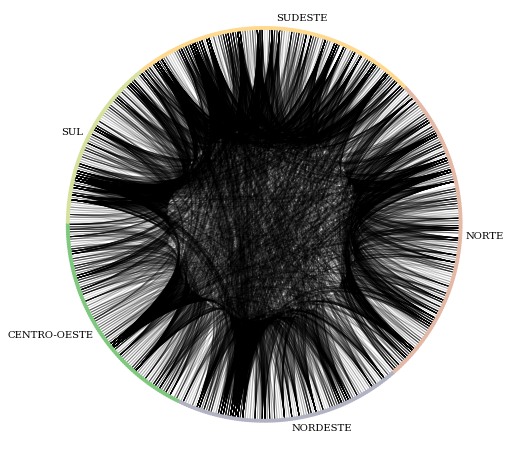

In [11]:
from nxviz.plots import CircosPlot

c = CircosPlot(H,
               node_color='region', 
               node_grouping='region',
               node_order="region",
               group_order="alphabetically",
               group_legend=False,
               node_labels=False,
               group_label_position="middle",
               group_label_color=False,figsize=(10,8))
c.draw()
plt.show()

<font>A partir deste gráfico pode-se verificar que a informação do ponto anterior permanece. Observe que as partes mais escuras do gráfico estão mais situadas nos pontos onde há um link entre uma região e ela mesma, enquanto que entre regiões, mesmo tendo muitos links, há uma quantidade visivelmente menor. </font>

### 2 Realizar uma análise bivariada entre o grau do vértice e o número médio de vizinhos.

- 2.1 Gerar um gráfico similar considerando a rede do Brasil e de todas as Regiões (Norte, Nordeste, Sul, Sudeste e Centro-Oeste).

In [12]:
degree, avg_neigh_degree = zip(*nx.average_degree_connectivity(H).items())

# convert to list
degree = list(degree)
avg_neigh_degree = list(avg_neigh_degree)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


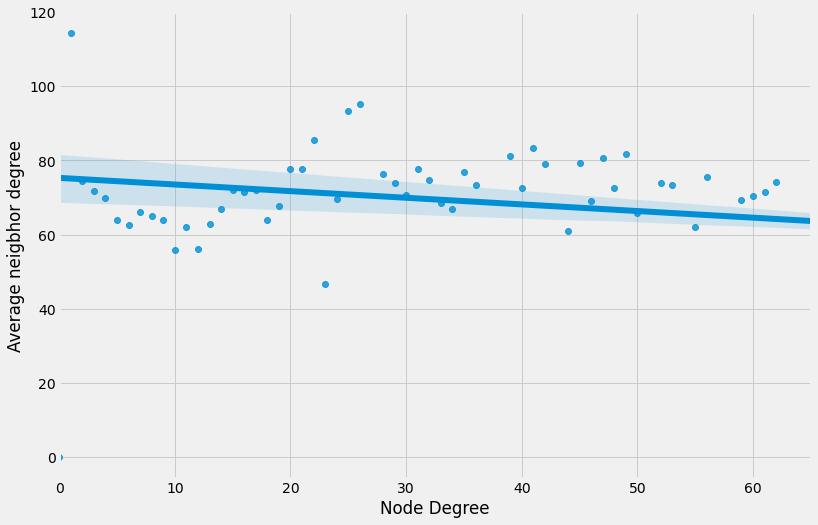

In [13]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(12,8))

sns.regplot(degree,avg_neigh_degree,ax=ax)

ax.set_xlabel("Node Degree")
ax.set_ylabel("Average neigbhor degree")
ax.set_xlim(0,65)

plt.show()

- 2.2 Fazer um relato dos principais achados

<font> Pelo grafíco notasse que quanto maior o grau do vértice menor tende a ser o grau médio de seus vizinhos. Isso implica lógicamente em uma disassortatividade atravéz do grau, fazendo com que haja uma iteração entre grupos diferentes. </font>

### 3. Quantos componentes conectados existem na malha aérea brasileira?
- Caracterize cada componente: quantidade, porcentagem por região


In [14]:
# Checking if H is connected
nx.is_connected(H)

False

In [15]:
# How many components exists in H
len(list(nx.connected_components(H)))

5

In [16]:
# Catching the size of sub graphics
for component in list(nx.connected_components(H)):
    print(len(component))

491
1
1
1
1


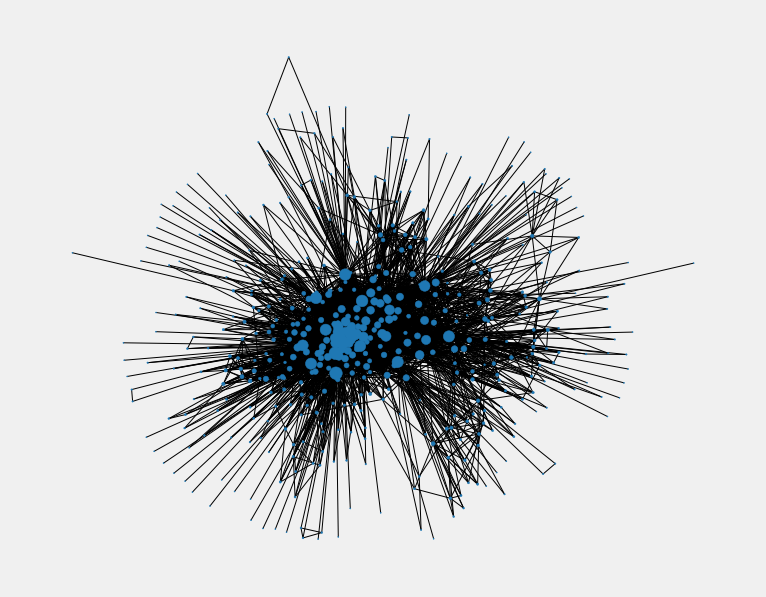

In [17]:
# Showing the bigger component of H
fig, ax = plt.subplots(1,1,figsize=(12,10))
subgraph = nx.subgraph(H, list(nx.connected_components(H))[0])
nx.draw_networkx(subgraph, pos=nx.spring_layout(subgraph),
                 node_size=[value for key, value in nx.degree(subgraph)],
                 ax = ax,with_labels=False)
ax.axis("off")
plt.show()


# Eu não fiz a imagem de um grafo usando como referência latitude e longitude, pois dá erro ao tentar colocar um ponto em -40.

In [18]:
# Counting the regions of Brazil found in each component of the graph
count_list = [1, 2, 3, 4, 5]
count = 1
component_H = {1: {}, 2:{}, 3:{}, 4:{}, 5:{}}
for component in list(nx.connected_components(H)):
  for node in component:
    if H.nodes[node]['region'] in component_H[count]:
      component_H[count][H.nodes[node]['region']] += 1
    else:
      component_H[count][H.nodes[node]['region']] = 1
  count += 1

component_H

{1: {'CENTRO-OESTE': 88,
  'NORDESTE': 92,
  'NORTE': 126,
  'SUDESTE': 115,
  'SUL': 70},
 2: {'SUDESTE': 1},
 3: {'NORTE': 1},
 4: {'NORTE': 1},
 5: {'CENTRO-OESTE': 1}}

In [19]:
component_H_percentage = {1: {'NORDESTE': 92/491, 'SUDESTE': 115/491, 'CENTRO-OESTE': 88/491, 'NORTE': 126/491, 'SUL': 70/491},
                          2:{'NORTE': 1/1},
                          3:{'SUDESTE': 1/1},
                          4:{'CENTRO-OESTE': 1/1},
                          5:{'NORTE': 1/1}}

component_H_percentage

{1: {'CENTRO-OESTE': 0.17922606924643583,
  'NORDESTE': 0.18737270875763748,
  'NORTE': 0.25661914460285135,
  'SUDESTE': 0.23421588594704684,
  'SUL': 0.1425661914460285},
 2: {'NORTE': 1.0},
 3: {'SUDESTE': 1.0},
 4: {'CENTRO-OESTE': 1.0},
 5: {'NORTE': 1.0}}

<font> Como foi demonstrado nas células anteriores, no Brasil há 5 subgrafos(componentes) dentro do grafo geral referente aos aeroportos do Brasil. O primeiro subgrafo tem um total de 491 "nodes"(aeroportos), onde se é distribuido em 92(18,7%) aeroportos na região nordeste, 115(23,4%) aeroportos na região sudeste, 88(17,9%) aeroportos na região centro-oeste, 126(25,6%) aeroportos na região norte e por fim 70(14,2%) aeroportos na região sul. Além desse subgrafo existem outros 4, como foram mostrados nas células de código, contudo contendo apenas um nó cada um deles, onde no subgrafo 2, há um aeroporto da região norte, no subgrafo 3, há um aeroporto da região sudeste, noo subgrafo 4, há um aeroporto da região centro-oeste e no subgrafo 5, há um aeroporto na região norte.</font>

### 4 Crie um cenário simulado, onde se deseja fazer uma viagem com o seguinte trajeto:
- cidade 1 (Norte) para cidade 2 (Sul)
- cidade 2 (Sul) para cidade 3 (Nordeste)
- cidade 3 (Nordeste) para cidade 4 (Centro-Oeste)
- cidade 4 (Centro-Oeste) para cidade 5 (Sudeste)


In [20]:
# Picking up 5 airports located in 5 different regions
norte_city = ''
sul_city = ''
nordeste_city = ''
centro_oeste_city = ''
sudeste_city = ''
count = 0

for a in H.nodes():
  if norte_city == '' and H.nodes[a]['region'] == 'NORTE':
    norte_city = a
    count += 1
  if sul_city == '' and H.nodes[a]['region'] == 'SUL':
    sul_city = a
    count += 1
  if nordeste_city == '' and H.nodes[a]['region'] == 'NORDESTE':
    nordeste_city = a
    count += 1
  if centro_oeste_city == '' and H.nodes[a]['region'] == 'CENTRO-OESTE':
    centro_oeste_city = a
    count += 1
  if sudeste_city == '' and H.nodes[a]['region'] == 'SUDESTE':
    sudeste_city = a
    count += 1
  if count == 5:
    break

In [21]:
print("norte: ",norte_city,
"| sul: ",sul_city,
"| nordeste: ",nordeste_city,
"| centro-oeste: ",centro_oeste_city,
"| sudeste: ",sudeste_city)

norte:  SNVS | sul:  SBFI | nordeste:  SNIP | centro-oeste:  SBDO | sudeste:  SBAS


In [22]:
# Norte -> Sul
nx.shortest_path(H, 'SWNK', 'SSVL')

['SWNK', 'SBEG', 'SBCT', 'SSVL']

In [23]:
# Sul -> Nordeste
nx.shortest_path(H, 'SSVL', 'SNAV')

['SSVL', 'SBCT', 'SBSV', 'SNAV']

In [24]:
# Nordeste -> centro_oeste
nx.shortest_path(H, 'SNAV', 'SBMC')

['SNAV', 'SBSV', 'SBBE', 'SBMC']

In [25]:
# centro_oeste -> sudeste
nx.shortest_path(H, 'SBMC', 'SNMX')

['SBMC', 'SBBE', 'SBRJ', 'SNMX']

<font> Para esse trajeto passando por SWNK(norte), SSVL(sul), SNAV(nordeste), SBMC(centro-oeste) e SNMX(sudeste) respectivamente, utilizando do caminho mais curto, temos que o trajeto é:<br>
[ 'SWNK', 'SBEG', 'SBCT', 'SSVL', 'SBCT', 'SBSV', 'SNAV', 'SBSV', 'SBBE', 'SBMC' , 'SBBE', 'SBRJ', 'SNMX' ]</font>

### 5. Realizar um estudo sobre o Coeficiente de Clustering considerando a Rede da Malha Aérea Nacional, assim como as sub-redes aéreas de cada Região (Norte, Nordeste, Centro-Oeste, Sul e Sudeste)

In [26]:
# Separating cities by regions
all_city_norte = []
all_city_nordeste = []
all_city_centro_oeste = []
all_city_sul = []
all_city_sudeste = []

for key, data in H.nodes(data=True):
  if data["region"] == 'NORTE':
    all_city_norte.append(key)
  if data["region"] == 'NORDESTE':
    all_city_nordeste.append(key)
  if data["region"] == 'CENTRO-OESTE':
    all_city_centro_oeste.append(key)
  if data["region"] == 'SUL':
    all_city_sul.append(key)
  if data["region"] == 'SUDESTE':
    all_city_sudeste.append(key)

In [27]:
# Creating subgraphs of H referring to each region
H_norte = H.subgraph(all_city_norte)
H_nordeste = H.subgraph(all_city_nordeste)
H_centro_oeste = H.subgraph(all_city_centro_oeste)
H_sul = H.subgraph(all_city_sul)
H_sudeste = H.subgraph(all_city_sudeste)

In [28]:
# Making the average clustering of National Air Mesh Network
nx.average_clustering(H)

0.6230508002369362

In [29]:
# Making the average clustering of airports in the region = 'NORTE'
nx.average_clustering(H_norte)

0.6159653188854737

In [30]:
# Making the average clustering of airports in the region = 'NORDESTE'
nx.average_clustering(H_nordeste)

0.43807384418290296

In [31]:
# Making the average clustering of airports in the region = 'CENTRO-OESTE'
nx.average_clustering(H_centro_oeste)

0.5618772358860068

In [32]:
# Making the average clustering of airports in the region = 'SUL'
nx.average_clustering(H_sul)

0.5979416718387065

In [33]:
# Making the average clustering of airports in the region = 'SUDESTE'
nx.average_clustering(H_sudeste)

0.6186700538769273

<font> Falando primeiramente sobre a rede da malha aérea nacional, temos que o seu Coeficiente de Clustering dado na célula de código é de aproximadamente 0.62, mostrando que ele está ligeiramente longe de ser uma topologia em estrela, chegando mais próximo da conexão entre todos os nós, contudo, não totalmente, pois para ter uma rede completa, onde todos os nós se ligam, o cálculo do Coeficiente de Clustering deveria ser 1. <br>
Com relação as sub-redes, referentes às regiões do Brasil, seus Coeficiente de Clustering ficam próximas de 0.6, dando a entender que estão de certa forma longe de ser uma topologia em estrela, igualmente a malha nacional. Contudo, existe uma região onde há um resultado menor que 0.5, que é dada no subgrafo da região nordeste, onde se tem o valor de 0.43(0.44 arredondando), mesmo tendo um valor relativamente longe de 0, indicando uma rede com nodes mais ligados e se distanciando de ser uma topologia em estrela.

Portanto, a malha aérea nacional Brasileira e suas sub malhas, referentes as suas regiões, tem o resultado do Coeficiente de Clustering indicando que nenhuma é uma topologia em estrela, tendo uma ligação que se distancia também de ser uma rede completa.
</font>